# Exploring at Raw Data

Looking at the raw data

# Packages

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean Data

Path Management

In [2]:
data_path = r"C:\Users\Diego\Desktop\app_prod\research\CreditMomentum\data"
credit_path = r"C:\Users\Diego\Desktop\app_prod\BBGData\credit_indices_data"
bbg_data_path = r"C:\Users\Diego\Desktop\app_prod\BBGData\root\BBGTickers.xlsx"
bbg_data = r"C:\Users\Diego\Desktop\app_prod\BBGData\data"

# Credit Data

In [3]:
data_prep_path = os.path.join(data_path, "data_guide.xlsx")
df_credit_guide = (pd.read_excel(
    io = data_prep_path, sheet_name = "credit_indices"))

In [4]:
df_credit_raw = (pd.read_parquet(
    path = credit_path, engine = "pyarrow").
    drop(columns = ["variable"]).
    merge(right = df_credit_guide, how = "inner", on = ["security"]))

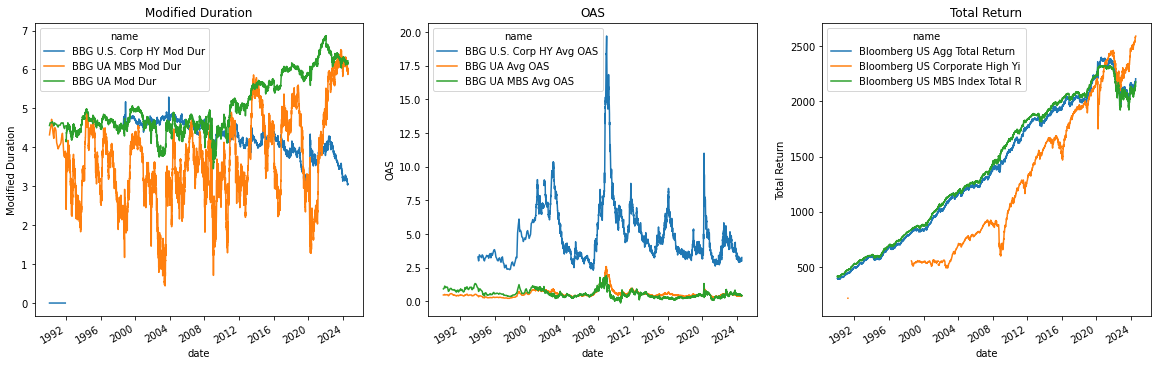

In [5]:
groups = (df_credit_raw[
    ["group_long"]].
    groupby("group_long").
    head(1).
    group_long.
    sort_values().
    to_list())

fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))
for group, ax in zip(groups, axes.flatten()):

    (df_credit_raw.query(
        "group_long == @group")
        [["name", "date", "value"]].
        pivot(index = "date", columns = "name", values = "value").
        plot(
            ax = ax,
            title = group,
            ylabel = group))

# CDS Tickers

In [6]:
df_cds_tickers_raw = (pd.read_excel(
    io = bbg_data_path, sheet_name = "cds_tickers")
    [["Security", "Description"]].
    assign(file_name = lambda x: x.Description.str.replace(" ", "") + ".parquet"))

df_cds_raw = pd.concat([
    pd.read_parquet(
        path = os.path.join(bbg_data, name), 
        engine = "pyarrow") 
    for name in df_cds_tickers_raw.file_name.to_list()])

In [7]:
df_cds_name = (pd.read_excel(
    io = data_prep_path, sheet_name = "cds_indices").
    assign(spec_name = lambda x: x.name + " " + x.maturity))

In [8]:
matched_names = (df_cds_name[
    ["spec_name", "maturity"]].
    groupby("spec_name").
    agg("count").
    query("maturity == 2").
    index.
    to_list())

index_only_names = (df_cds_name.query(
    "spec_name != @matched_names").
    query("group == 'Index'").
    spec_name.
    to_list())

combined_names = matched_names + index_only_names
security = (df_cds_name.query(
    "spec_name == @combined_names").
    security.
    to_list())

df_cds = (df_cds_raw.query(
    "security == @security").
    merge(right = df_cds_name, how = "inner", on = ["security"]).
    assign(unique_name = lambda x: x.name + " " + x.maturity))

In [9]:
cds_names = (df_cds[
    ["unique_name"]].
    groupby("unique_name").
    head(1).
    unique_name.
    to_list())

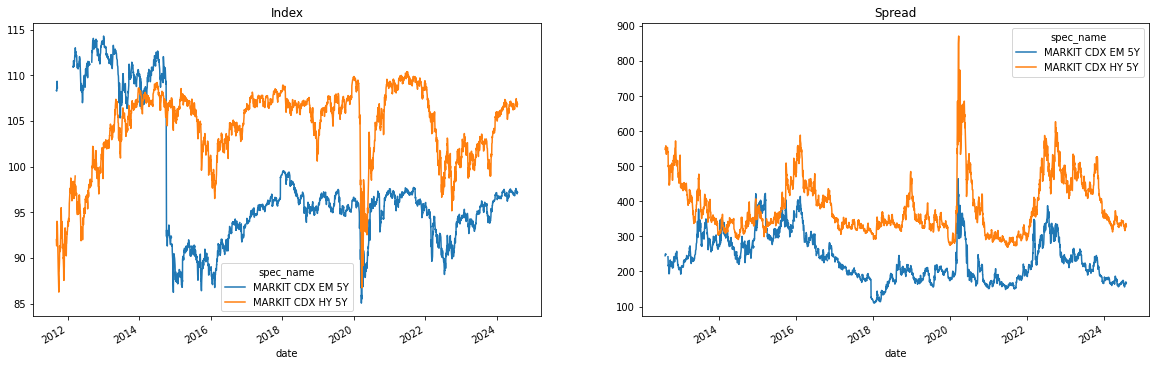

In [11]:
df_matched = df_cds.query("spec_name == @matched_names")
groups = ["Index", "Spread"]

fig, axes = plt.subplots(ncols = len(groups), figsize = (20,6))
for group, ax in zip(groups, axes.flatten()):
    
    (df_matched.query(
        "group == @group")
        [["spec_name", "date", "value"]].
        pivot(index = "date", columns = "spec_name", values = "value").
        plot(
            title = group,
            ax = ax))

<AxesSubplot:xlabel='date'>

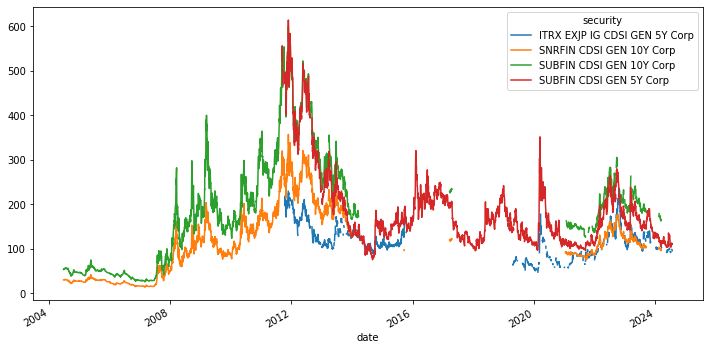

In [16]:
(df_cds.query(
    "spec_name == @index_only_names")
    [["security", "date", "value"]].
    pivot(index = "date", columns = "security", values = "value").
    plot(
        figsize = (12,6)))